In [76]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels

# Example 2: Adapting to an elastic half-space

In this notebook, we will demonstrate how to use full-space greens functions and an appropriate set of boundary conditions to compute displacements and stresses in a half-space. The basic methodology we will follow is:
1. Construct a mesh of the top of the half-space 
2. Create a source and compute the required tractions at the previously constructed mesh
3. Solve the boundary value problem where the top of the half-space is traction-free i.e., $\hat{n}.\sigma = 0$
4. The solution to the BVP gives us fictitious slip distribution in terms of 3qn coefficients for our mesh. Use these coefficients to calculate displacements and stresses everywhere *inside* the medium

## Constructing a half-space
Below we first construct a 1-d line mesh of the top of the half-space or a flat topography. This is where we will solve a boundary value problem to compute the half-space solutions.

In [77]:
# Elastic parameters
mu = 1
nu = 0.25

# create a uniform mesh of the free surface
n_elements = 50 # only even number
L_fault = 100 # fault length in x
xlogvals = np.logspace(-1.,np.log10(L_fault/2),int(n_elements/2))
# xmesh = np.linspace(-L_fault/2,L_fault/2,n_elements+1)
xmesh = np.concatenate((-xlogvals[::-1],[0.],xlogvals))
x1 = xmesh[0:-1]
x2 = xmesh[1:]
y1 = 0*x1 + 1e-16
y2 = 0*x2 + 1e-16

elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)

# unit vector in normal direction
nvec = np.zeros((n_elements,2))
for i in range(n_elements):
    nvec[i,:] = np.array((elements[i]["x_normal"],elements[i]["y_normal"]))

# patch center locations (need to be shifted an infinitesimal amount in -ve unit normal direction)
x_obs = np.zeros((n_elements,1)) 
y_obs = np.zeros((n_elements,1)) 
for i in range(n_elements):
    x_obs[i,0] = 0.5*(elements[i]["x1"]+elements[i]["x2"]) - nvec[i,0]*1e-16
    y_obs[i,0] = 0.5*(elements[i]["y1"]+elements[i]["y2"]) - nvec[i,1]*1e-16

## Generate a source

The tools we have are 
- displacement and stresses everywhere in a full-space from 3qn greens functions
- a 1-d mesh of the free surface

We now need to create a finite dimension source with unit slip. This unit slip causes a stress change everywhere in the medium, and specifically at the central nodes of our 1-d mesh. We project the stress tensor onto the unit normal for every fault element to get a traction vector. 
$\begin{equation}
\underline{t} = \begin{bmatrix} t_x \\ t_y \end{bmatrix} = \begin{bmatrix} n_x & n_y \end{bmatrix} . \begin{bmatrix} \sigma_{xx} & \sigma_{xy} \\ \sigma_{xy} & \sigma_{yy} \end{bmatrix} 
\end{equation}$

IN BEMCS - physical_displacements=array([1., 1., 1.])
IN BEMCS - quadratic_coefficients=array([1., 1., 1.])


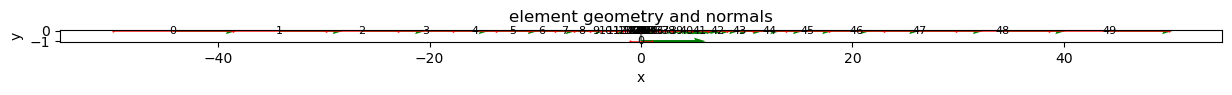

In [78]:
# create a source (use constant slip)
element = {}
source = []
element["x1"] = -1.
element["x2"] = 1.0
element["y1"] = -1.0
element["y2"] = -1.0
source.append(element.copy())
source = bemcs.standardize_elements(source)

quadratic_source = bemcs.get_quadratic_coefficients_for_linear_slip(source[0]["half_length"], 
    np.array((-source[0]["half_length"],0,source[0]["half_length"])), 1., 1.).reshape((-1,1))

# compute stress change from source to elements
kernels_source_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,source,mu,nu,1)

# project stress tensor to traction vector for every element
tsource_x = (kernels_source_s[0]@quadratic_source)*nvec[:,0].reshape(-1,1) + (kernels_source_s[2]@quadratic_source)*nvec[:,1].reshape(-1,1)
tsource_y = (kernels_source_s[2]@quadratic_source)*nvec[:,0].reshape(-1,1) + (kernels_source_s[1]@quadratic_source)*nvec[:,1].reshape(-1,1)

plt.figure(figsize=(15,10))
bemcs.plot_element_geometry(elements)
bemcs.plot_element_geometry(source)
plt.show()

In [79]:
# compute shear and tensile stress kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

# convert to traction kernels [Nobs x Ncoefficients]
# tx = Kxx*nx + Kxy*ny
# ty = Kxy*nx + Kyy*ny
tractionkernels_s = kernels.compute_tractionkernels(elements,kernels_s)
tractionkernels_n = kernels.compute_tractionkernels(elements,kernels_n)


## Solve a boundary value problem

The presence of a free-surface means that $\underline{t} = 0$ for this mesh. To solve this problem, we need to find a distribution of slip over the fault mesh that will result in traction-free conditions. 
- We have $N$ elements, with $6N$ unknown slip coefficients - $q_s,q_n$
- Traction-free boundary conditions at $N$ element central nodes are written as $\begin{bmatrix} t_x^s \\ t_y^s\end{bmatrix} + [K]\begin{bmatrix} q_s \\ q_n \end{bmatrix} = \begin{bmatrix} 0 \\ 0\end{bmatrix}$
- $2\times(N-1)$ slip continuity, $2\times(N-1)$ slip smoothness conditions at nodes that overlap between neighboring fault elements
- $4$ slip or slip gradient conditions at the boundary nodes

With this, the system is closed and we can find a unique set of $q_s,q_n$ coefficients for all fault elements.

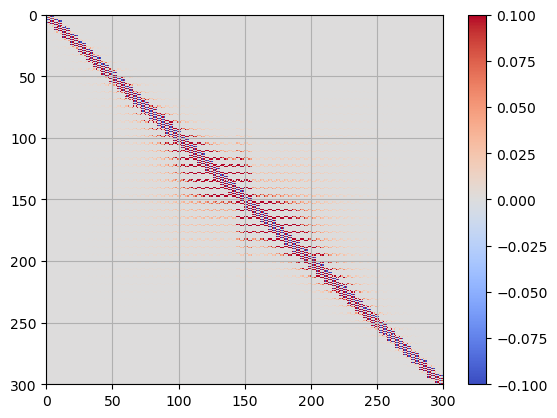

In [80]:
# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements)

matrix_system = np.zeros((len(elements)*6,len(elements)*6))

BCvector = np.zeros((len(elements)*6,1))
# slip OR slip gradients at the boundaries (we set them to 0 here)
BCvector[0:2] = 0.
BCvector[-2:] = 0.
# traction-free boundary condition for element centers
BCvector[2:-3:6] = -tsource_x
BCvector[3:-2:6] = -tsource_y

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
matrix_system[0:2,:] = matrix_slipgradient[0:2:]
matrix_system[-2:,:] = matrix_slipgradient[-2:,:]

# patch center nodes (for x,y components)
matrix_tx = np.zeros((len(elements),6*len(elements)))
matrix_ty = np.zeros((len(elements),6*len(elements)))
matrix_tx[:,0::6] = tractionkernels_s[0][:,0::3]
matrix_tx[:,1::6] = tractionkernels_s[0][:,1::3]
matrix_tx[:,2::6] = tractionkernels_s[0][:,2::3]
matrix_tx[:,3::6] = tractionkernels_n[0][:,0::3]
matrix_tx[:,4::6] = tractionkernels_n[0][:,1::3]
matrix_tx[:,5::6] = tractionkernels_n[0][:,2::3]
matrix_ty[:,0::6] = tractionkernels_s[1][:,0::3]
matrix_ty[:,1::6] = tractionkernels_s[1][:,1::3]
matrix_ty[:,2::6] = tractionkernels_s[1][:,2::3]
matrix_ty[:,3::6] = tractionkernels_n[1][:,0::3]
matrix_ty[:,4::6] = tractionkernels_n[1][:,1::3]
matrix_ty[:,5::6] = tractionkernels_n[1][:,2::3]
matrix_system[2:-3:6,:] = matrix_tx # x component
matrix_system[3:-2:6,:] = matrix_ty # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# continuity
matrix_system[4:-7:6,:] = matrix_slip[4:-7:6,:] - matrix_slip[6:-5:6,:]# x component
matrix_system[5:-6:6,:] = matrix_slip[5:-6:6,:] - matrix_slip[7:-4:6,:]# y component
# smoothness
matrix_system[6:-5:6,:] = matrix_slipgradient[4:-7:6,:] - matrix_slipgradient[6:-5:6,:]# x component
matrix_system[7:-4:6,:] = matrix_slipgradient[5:-6:6,:] - matrix_slipgradient[7:-4:6,:]# y component 

# plot design matrix
_,ax = plt.subplots()
pc = ax.pcolor(matrix_system,cmap="coolwarm",shading='flat')
# pc = ax.pcolor(kernels_s[2],cmap="coolwarm",shading='flat')
ax.grid(which='both')
ax.invert_yaxis()
pc.set_clim(-0.1,0.1)
plt.colorbar(pc)
plt.show()

# # compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]

## Calculate displacements and stresses in a half-space

In [81]:
n_obs = 100
width = 3
x_plot = np.linspace(-width, width, n_obs)
y_plot = np.linspace(-width, 0, n_obs)

x_plot, y_plot = np.meshgrid(x_plot, y_plot)
x_plot = x_plot.flatten()
y_plot = y_plot.flatten()

# compute shear and tensile kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_source_s = kernels.get_quadratic_displacement_stress_kernel(x_plot,y_plot,source,mu,nu,1)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_plot,y_plot,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_plot,y_plot,elements,mu,nu,0)

# compute displacements and stresses (we will plot it later)
ux = kernels_source_s[3] @ (quadratic_source) + kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_source_s[4] @ (quadratic_source) + kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_source_s[0] @ (quadratic_source) + kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_source_s[1] @ (quadratic_source) + kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_source_s[2] @ (quadratic_source) + kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/../bemcs/bemcs.py:402: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/../bemcs/bemcs.py:402: RuntimeWarning: invalid value encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/../bemcs/bemcs.py:403: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/../bemcs/bemcs.py:403: RuntimeWarning: invalid value encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/../bemcs/bemcs.py:413: RuntimeWarning: divide by zero encountered in log
 

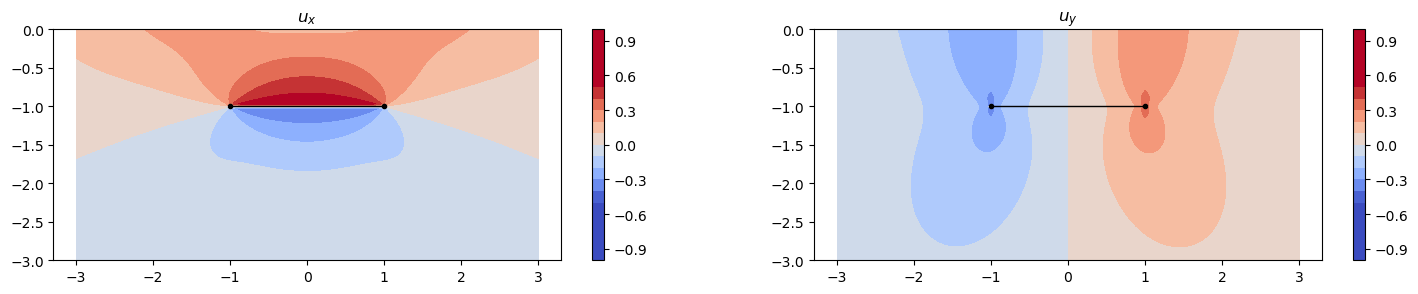

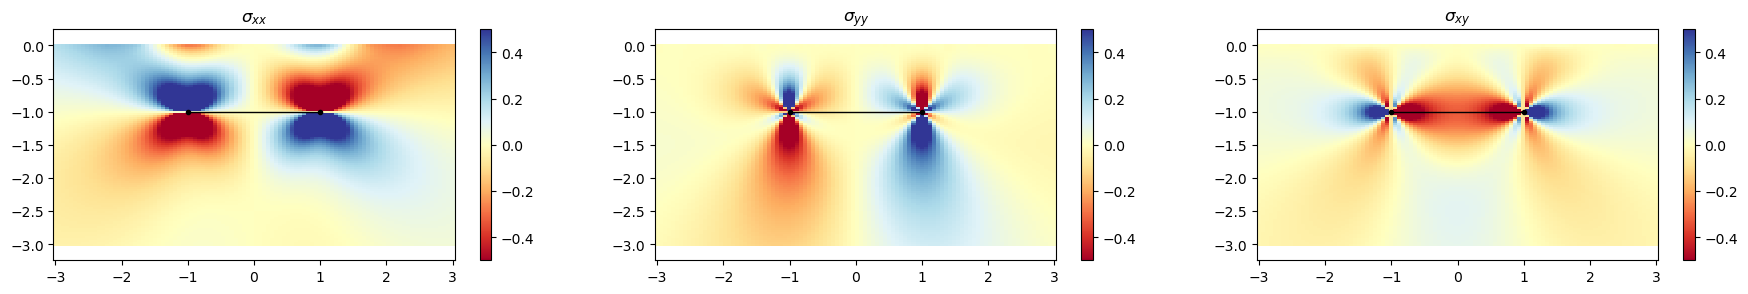

In [82]:
# displacements
plt.figure(figsize=(18,3))
plt.subplot(1, 2, 1)
plt.contourf(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), ux.reshape(n_obs, n_obs),cmap='coolwarm',levels=np.linspace(-1., 1., 21),vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
# plt.quiver(x_plot[0::nskip_plot],y_plot[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.axis("equal")
plt.title("$u_x$")

plt.subplot(1, 2, 2)
plt.contourf(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), uy.reshape(n_obs, n_obs),cmap='coolwarm',levels=np.linspace(-1., 1., 21),vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
# plt.quiver(x_plot[0::nskip_plot],y_plot[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.title("$u_y$")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
toplot = sxx
# plt.contourf(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-0.5, 0.5, 21),cmap='RdYlBu',vmin=-0.5,vmax=0.5)
plt.pcolor(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
# for element in elements:
#     plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
# plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = syy
# plt.contourf(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-0.5, 0.5, 21),cmap='RdYlBu',vmin=-0.5,vmax=0.5)
plt.pcolor(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
# for element in elements:
#     plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
# plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = sxy
# plt.contourf(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-0.5, 0.5, 21),cmap='RdYlBu',vmin=-0.5,vmax=0.5)
plt.pcolor(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
plt.colorbar()
# plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()

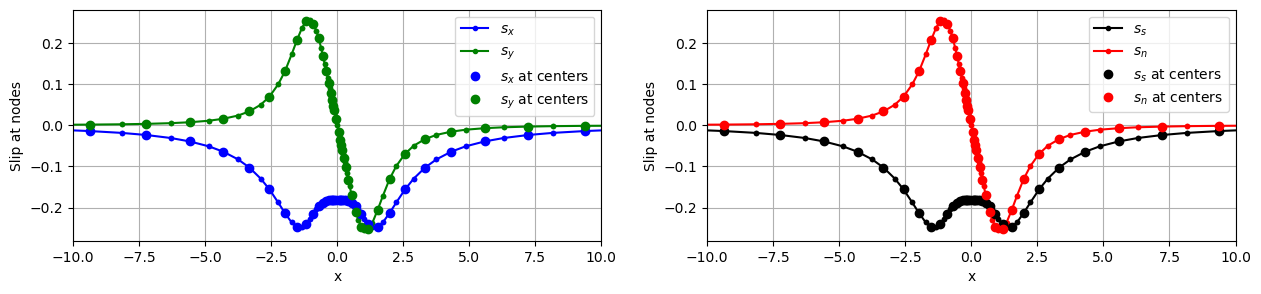

In [83]:
# extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x,slip_nodes_y))
# rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3*len(elements),1))
slip_nodes_n = np.zeros((3*len(elements),1))

for i in range(len(elements)):
    dummy = slip_vector[3*i:3*(i+1),:]@elements[i]["rotation_matrix"]
    slip_nodes_s[3*i:3*(i+1),0] = dummy[:,0]
    slip_nodes_n[3*i:3*(i+1),0] = dummy[:,1]

xnodes = np.zeros((3*len(elements),1))
xnodes[0::3,0] = x1
xnodes[2::3,0] = x2
xnodes[1::3,0] = 0.5*(x1 + x2)

plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(xnodes,slip_nodes_x,'b.-',label='$s_x$')
plt.plot(xnodes,slip_nodes_y,'g.-',label='$s_y$')
plt.plot(xnodes[1:-1:3,0],slip_nodes_x[1:-1:3,0],'bo',label='$s_x$ at centers')
plt.plot(xnodes[1:-1:3,0],slip_nodes_y[1:-1:3,0],'go',label='$s_y$ at centers')
plt.xlabel("x")
plt.ylabel("Slip at nodes")
plt.legend()
plt.grid()
plt.xlim((-10,10))
plt.subplot(1,2,2)
plt.plot(xnodes,slip_nodes_s,'k.-',label='$s_s$')
plt.plot(xnodes,slip_nodes_n,'r.-',label='$s_n$')
plt.plot(xnodes[1:-1:3,0],slip_nodes_s[1:-1:3,0],'ko',label='$s_s$ at centers')
plt.plot(xnodes[1:-1:3,0],slip_nodes_n[1:-1:3,0],'ro',label='$s_n$ at centers')
plt.xlabel("x")
plt.ylabel("Slip at nodes")
plt.legend()
plt.grid()
plt.xlim((-10,10))
plt.show()

## Compare solution with analaytical solutions for a half-space

/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/halfspace_greensfunctions.py:67: RuntimeWarning: divide by zero encountered in log
  FF2 = con * (np.log(np.sqrt(R1S)) - np.log(np.sqrt(R2S)))
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/halfspace_greensfunctions.py:80: RuntimeWarning: invalid value encountered in divide
  FF4 = con * (YB / R1S - YB / R2S)
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/halfspace_greensfunctions.py:81: RuntimeWarning: invalid value encountered in divide
  FF5 = con * (XMa / R1S - XPa / R2S)
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/halfspace_greensfunctions.py:109: RuntimeWarning: invalid value encountered in multiply
  Ux = Dxb * (-pr1 * sb * FF2 + pr2 * cb * FF3 + YB * (sb * FF4 - cb * FF5)) \
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/halfspace_greensfunctions.py:112: RuntimeWarning: invalid value encountered in multiply
  + Dyb * (-pr1 * sb * FF2 + pr2 * cb * FF3 - YB

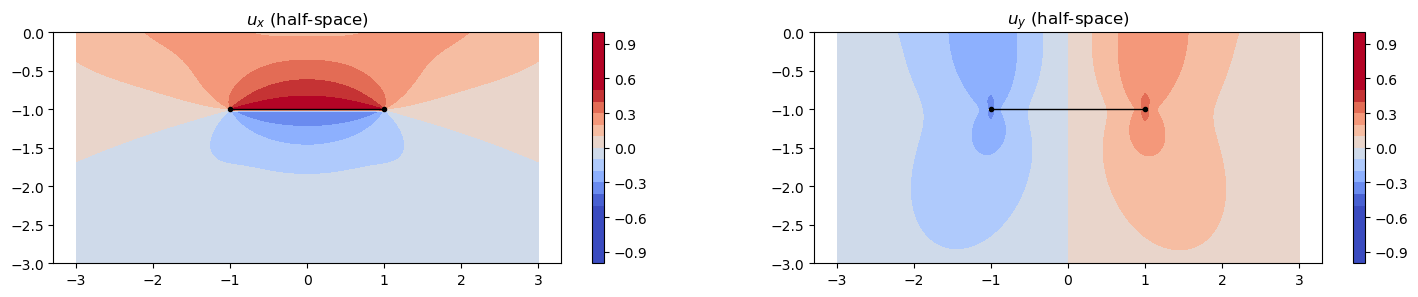

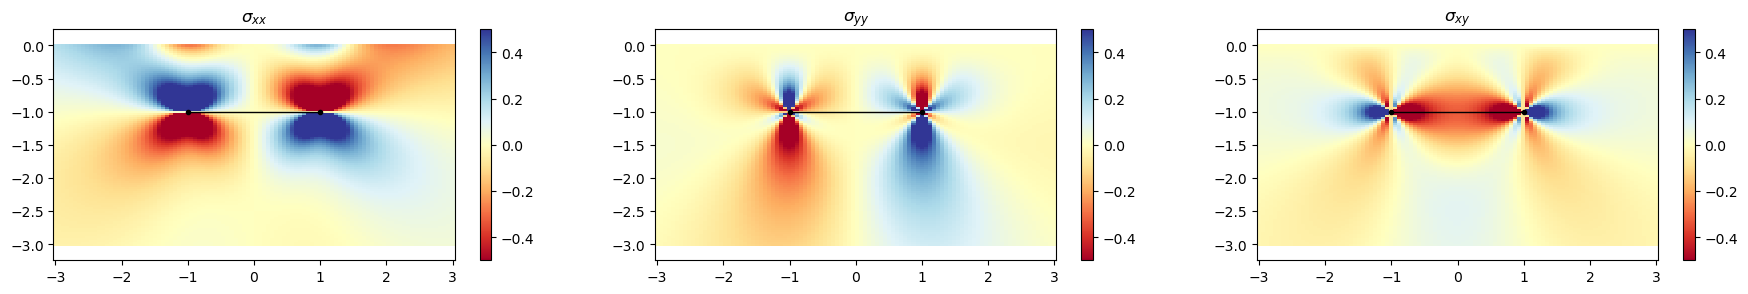

In [84]:
# Compute internal displacements for a half-space solution
import halfspace_greensfunctions as HS
ux_hs,uy_hs = HS.LDdispHS(x_plot.reshape(-1,1),y_plot.reshape(-1,1),
                          (source[0]["x1"]+source[0]["x2"])/2,(source[0]["y1"]+source[0]["y2"])/2,
                          source[0]["half_length"],-np.rad2deg(source[0]["angle"]),-1,0,nu)
sxx_hs,syy_hs,sxy_hs = HS.LDstressHS(x_plot.reshape(-1,1),y_plot.reshape(-1,1),
                          (source[0]["x1"]+source[0]["x2"])/2,(source[0]["y1"]+source[0]["y2"])/2,
                          source[0]["half_length"],-np.rad2deg(source[0]["angle"]),-1,0,nu,mu)

# displacements
plt.figure(figsize=(18,3))
plt.subplot(1, 2, 1)
plt.contourf(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), ux_hs.reshape(n_obs, n_obs),cmap='coolwarm',levels=np.linspace(-1., 1., 21),vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.axis("equal")
plt.title("$u_x$ (half-space)")

plt.subplot(1, 2, 2)
plt.contourf(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), uy_hs.reshape(n_obs, n_obs),cmap='coolwarm',levels=np.linspace(-1., 1., 21),vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.title("$u_y$ (half-space)")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
toplot = sxx_hs
plt.pcolor(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = syy_hs
plt.pcolor(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = sxy_hs
plt.pcolor(x_plot.reshape(n_obs, n_obs), y_plot.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-0.5,vmax=0.5)
plt.plot([source[0]["x1"], source[0]["x2"]],[source[0]["y1"], source[0]["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()

### Comparisons at the free-surface

At the free surface, $\sigma_{xy},\sigma_{yy} = 0$. This is seen in the half-space analytical solutions while the BEM calculations have small errors in those 2 components. This can be remedied by increasing the number of elements in the mesh.

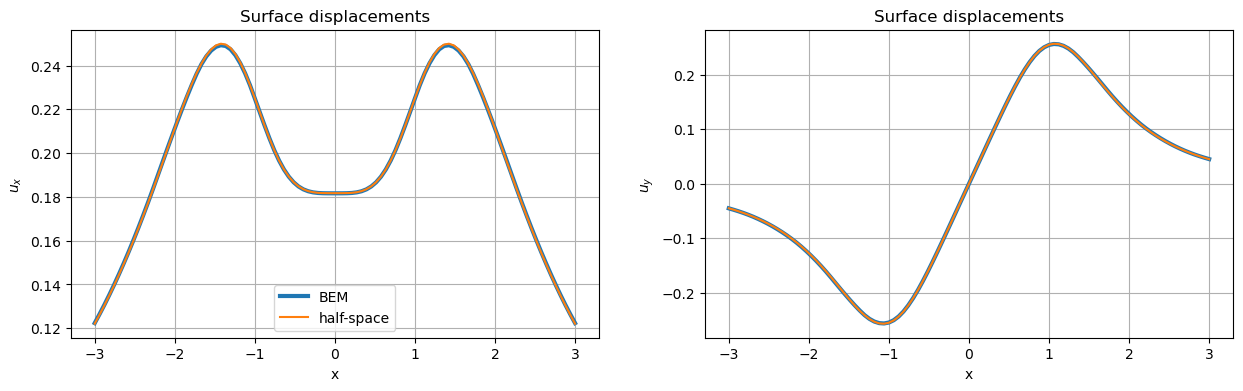

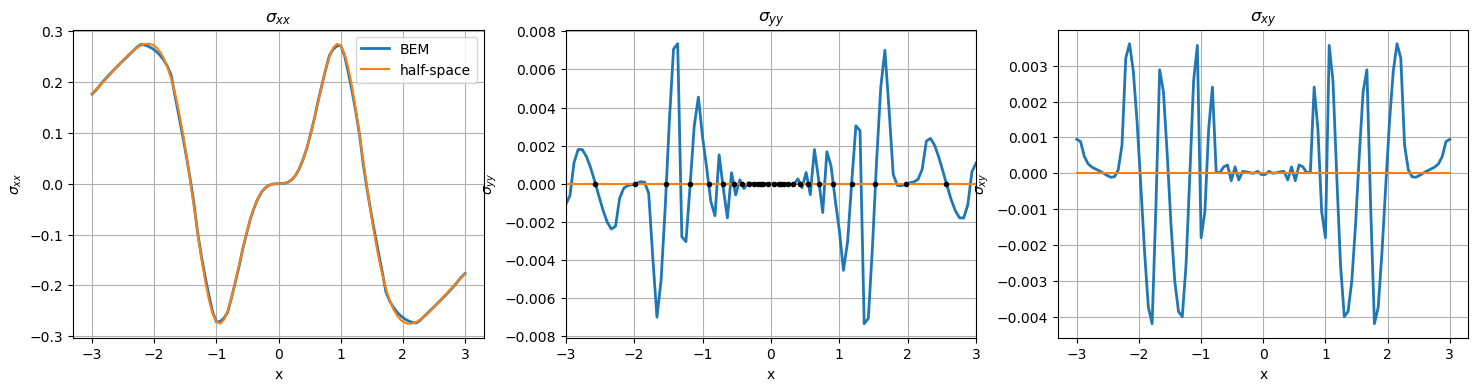

In [91]:
# compare surface displacements
# index = np.where((y_plot>-0.04) & (y_plot<0))
index = np.where(y_plot==0.)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(x_plot[index],ux[index],label='BEM',linewidth=3)
plt.plot(x_plot[index],ux_hs[index],label='half-space')
plt.xlabel('x')
plt.ylabel('$u_x$')
plt.legend()
plt.grid()
plt.title('Surface displacements')
plt.subplot(1,2,2)
plt.plot(x_plot[index],uy[index],linewidth=3)
plt.plot(x_plot[index],uy_hs[index])
plt.xlabel('x')
plt.ylabel('$u_y$')
plt.grid()
plt.title('Surface displacements')
plt.show()

plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(x_plot[index],sxx[index],label='BEM',linewidth=2)
plt.plot(x_plot[index],sxx_hs[index],label='half-space')
plt.xlabel('x')
plt.ylabel('$\sigma_{xx}$')
plt.legend()
plt.grid()
plt.title('$\sigma_{xx}$')
plt.subplot(1,3,2)
plt.plot(x_plot[index],syy[index],linewidth=2)
plt.plot(x_plot[index],syy_hs[index])
plt.plot(xnodes[1:-1:3,0],0*xnodes[1:-1:3,0],'k.')
plt.xlabel('x')
plt.ylabel('$\sigma_{yy}$')
plt.grid()
plt.xlim((-width,width))
plt.title('$\sigma_{yy}$')
plt.subplot(1,3,3)
plt.plot(x_plot[index],sxy[index],linewidth=2)
plt.plot(x_plot[index],sxy_hs[index])
plt.xlabel('x')
plt.ylabel('$\sigma_{xy}$')
plt.grid()
plt.title('$\sigma_{xy}$')
plt.show()